In [6]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb

# Získáme cestu k aktuální složce
current_dir = os.getcwd()

# Získáme cestu k NADŘAZENÉ složce (o úroveň výš)
parent_dir = os.path.dirname(current_dir)

# Přidáme nadřazenou složku do cest, kde Python hledá
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Teď už by měl Python "vidět" složku pzs_lib jako balíček
import pzs_lib as pzs
print("PZS Lib načtena úspěšně!")

plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline


PZS Lib načtena úspěšně!


In [ ]:

# --- 1. NAČTENÍ DAT (VOICED Databáze) ---
# Tady předpokládám, že budeš mít složku 'voiced/1.0.0/' a v ní soubory.
# Pro test si stáhni jeden zdravý (např. 'voice002') a jeden nemocný.

# Pokud používáš WFDB (dat/hea soubory):
record_name = 'voice001' # Zkus změnit na existující záznam
db_dir = 'voiced/1.0.0/' 

print(f"Zkouším načíst: {record_name}")

try:
    # Online stažení (pokud funguje)
    record = wfdb.rdrecord(record_name, pn_dir=db_dir)
    sig = record.p_signal[:, 0] # První kanál
    fs = record.fs
    print(f"Načteno. FS: {fs} Hz, Délka: {len(sig)/fs:.2f} s")
    
    # Diagnóza je často v komentářích hlavičky (.hea soubor)
    print("Komentáře (diagnóza):", record.comments)
    
except Exception as e:
    print("Chyba při načítání záznamu:", e)
    sys.exit(1)


Zkouším načíst: voice001
Načteno. FS: 8000 Hz, Délka: 4.76 s
Komentáře (diagnóza): ['<age>: 32  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none']


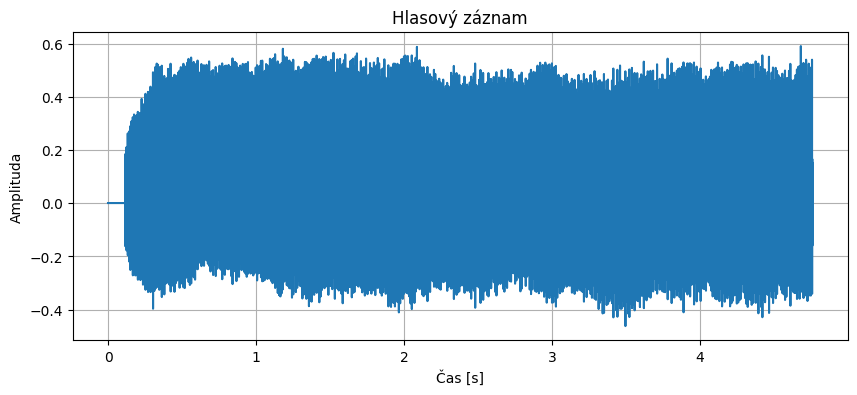

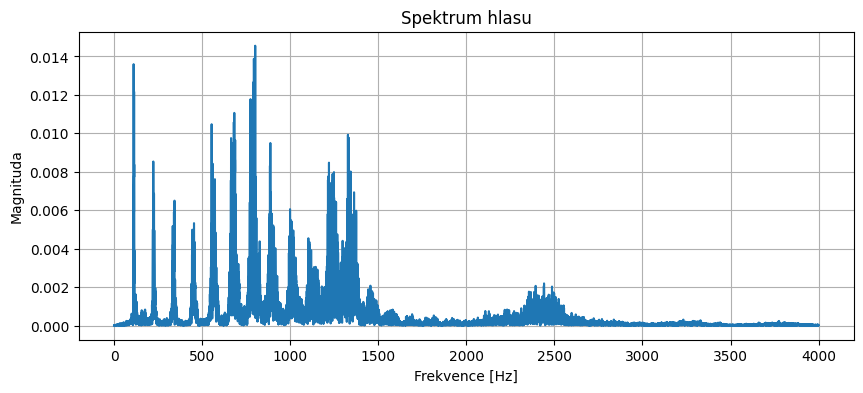

In [8]:

# --- 2. ZPRACOVÁNÍ A ANALÝZA ---

# Odstranění stejnosměrné složky
sig = sig - np.mean(sig)

# Analýza v čase
pzs.plot_time_signal(np.arange(len(sig))/fs, sig, title="Hlasový záznam")

# Frekvenční spektrum (FFT)
freqs, mag = pzs.get_frequency_spectrum(sig, fs)
pzs.plot_spectrum(freqs, mag, title="Spektrum hlasu")
# U zdravého hlasu bys měl vidět ostré 'hřeby' (harmonické).
# U nemocného to bude 'chlupaté' a hřeby se budou ztrácet v šumu.

--- VÝSLEDKY ANALÝZY ---
Detekovaná základní frekvence (F0): 112.68 Hz
Skóre kvality (výška píku):         0.2423


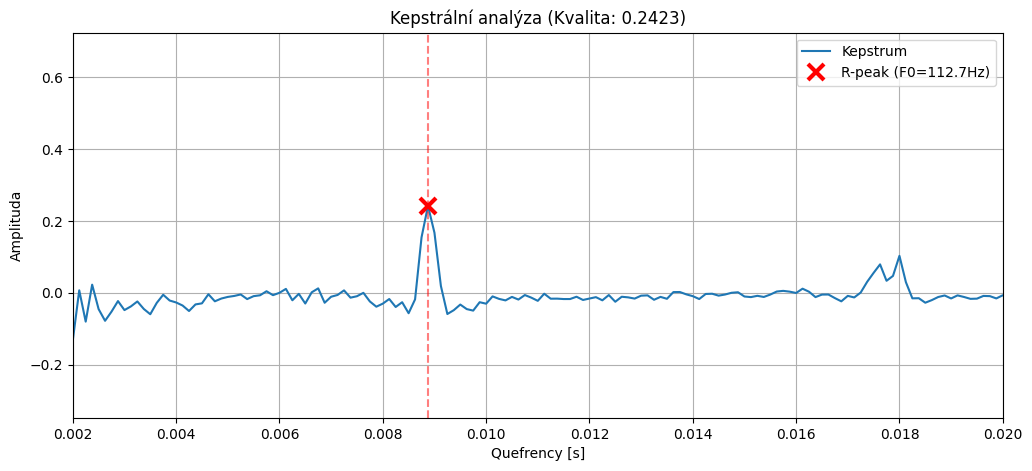

In [9]:
# --- 3. KEPSTRÁLNÍ ANALÝZA (Rozsekaná verze) ---

# A) Výpočet kepstra (jen matematika)
cepstrum_vals = pzs.compute_real_cepstrum(sig)

# Vytvoření osy 'quefrency' v sekundách pro graf
quefrency_time = np.arange(len(cepstrum_vals)) / fs

# B) Analýza (vytažení F0 a kvality)
# Hledáme hlas mezi 60 Hz a 350 Hz (běžný rozsah řeči)
f0, quality_score = pzs.analyze_voice_features(cepstrum_vals, fs, f_min=60, f_max=350)

print(f"--- VÝSLEDKY ANALÝZY ---")
print(f"Detekovaná základní frekvence (F0): {f0:.2f} Hz")
print(f"Skóre kvality (výška píku):         {quality_score:.4f}")

# C) Vizualizace
plt.figure(figsize=(12, 5))
plt.plot(quefrency_time, cepstrum_vals, label='Kepstrum')

# Zvýraznění nalezeného píku
if f0 > 0:
    peak_time = 1/f0
    plt.plot(peak_time, quality_score, 'rx', markersize=12, markeredgewidth=3, label=f'R-peak (F0={f0:.1f}Hz)')
    plt.axvline(peak_time, color='r', linestyle='--', alpha=0.5)

plt.title(f"Kepstrální analýza (Kvalita: {quality_score:.4f})")
plt.xlabel("Quefrency [s]")
plt.ylabel("Amplituda")
# Omezení grafu jen na relevantní oblast (např. 2ms až 20ms)
plt.xlim(0.002, 0.02) 
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# --- 4. ROZHODOVÁNÍ (Klasifikace) ---
# Tady si nastavíš práh podle toho, jak ti vyjdou hodnoty pro zdravé a nemocné
THRESHOLD = 0.05 

if quality_score > THRESHOLD:
    print("Hlas vyhodnocen jako: ZDRAVÝ (Normální)")
else:
    print("Hlas vyhodnocen jako: PATOLOGICKÝ (Nemocný)")

Hlas vyhodnocen jako: ZDRAVÝ (Normální)
